<script>
        var code_show=true; //true -> hide code at first
    
        function code_toggle() {
            $('div.prompt').hide(); // always hide prompt
            $('div[style*=\"border-style: dashed"\]').hide(); // hide extra comments, usually log from treasuredata
            $('div.output_stderr').parent().hide();
    
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("seaborn-poster")

# set random state
RND = 101

In [3]:
def plot_knn_error(X_train, y_train, X_test, y_test):
    error = []
    
    # Calculating error for K values between 1 and 40
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test))
    
    plt.figure(figsize=(12, 6))  
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    
    plt.title('Error rate using different k value')  
    plt.xlabel('k')
    plt.xticks(np.arange(1,40,2))
    plt.ylabel('Mean Error');
    
    return error

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

def show_model_performance(y_test, y_pred, avg='weighted'):
    print("Accuracy\t: {:.2%}".format(accuracy_score(y_test, y_pred)))
    print("Precision\t: {:.2%}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall\t\t: {:.2%}".format(recall_score(y_test, y_pred, average=avg)))
    print("F1-score\t: {:.2%}".format(f1_score(y_test, y_pred, average=avg)))
    print("\n")
    print(classification_report(y_test, y_pred)) 

# Introduction

## Background

Given list of football players and their skill, could we identify their preferred position on the pitch? Or perhaps, more generally, could we group them based on their skills? Since we already covered classification and clustering method on my previous posts, let's use it on this case!

## Research Questions

1. Could we identify football players' position if we know their skill?
2. Can we group football players based on their skill?

# Assumptions and Known Limitations

- To simplify class labels, we generalize players position into back, midfielder, forward, and goal keeper.
    - back: CB, LB, RB, LWB, RWB
    - midfielder: CDM, CAM, CM, RM, LM
    - forward: ST, CF, LW, RW
    - goal keeper: GK

# Data Preparation

We use FIFA 2018 dataset downloaded from [Kaggle](https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset/data). This dataset contains list of players: nationality, name, club, position, and skill - which are measured in range 0 to 100. 

In [5]:
df = pd.read_csv("dataset/fifa-2018-complete-dataset.csv")
df.rename(columns={'Unnamed: 0':'index'}, inplace=True)

df['Preferred Positions_Main'] = df['Preferred Positions'].apply(lambda x: x.split(' ')[0].strip())

In [6]:
# remove unnecessary columns
cols = [
    'Name'
    ,'Age'
    ,'Nationality'
    ,'Overall'
    ,'Potential'
    ,'Club'
    ,'Acceleration'
    ,'Aggression'
    ,'Agility'
    ,'Balance'
    ,'Ball control'
    ,'Composure'
    ,'Crossing'
    ,'Curve'
    ,'Dribbling'
    ,'Finishing'
    ,'Free kick accuracy'
    ,'GK diving'
    ,'GK handling'
    ,'GK kicking'
    ,'GK positioning'
    ,'GK reflexes'
    ,'Heading accuracy'
    ,'Interceptions'
    ,'Jumping'
    ,'Long passing'
    ,'Long shots'
    ,'Marking'
    ,'Penalties'
    ,'Positioning'
    ,'Reactions'
    ,'Short passing'
    ,'Shot power'
    ,'Sliding tackle'
    ,'Sprint speed'
    ,'Stamina'
    ,'Standing tackle'
    ,'Strength'
    ,'Vision'
    ,'Volleys'
    ,'Preferred Positions_Main'
]

df = df[cols].copy()

# convert columns to numeric
df = df.convert_objects(convert_numeric=True)

Dataset preview: 



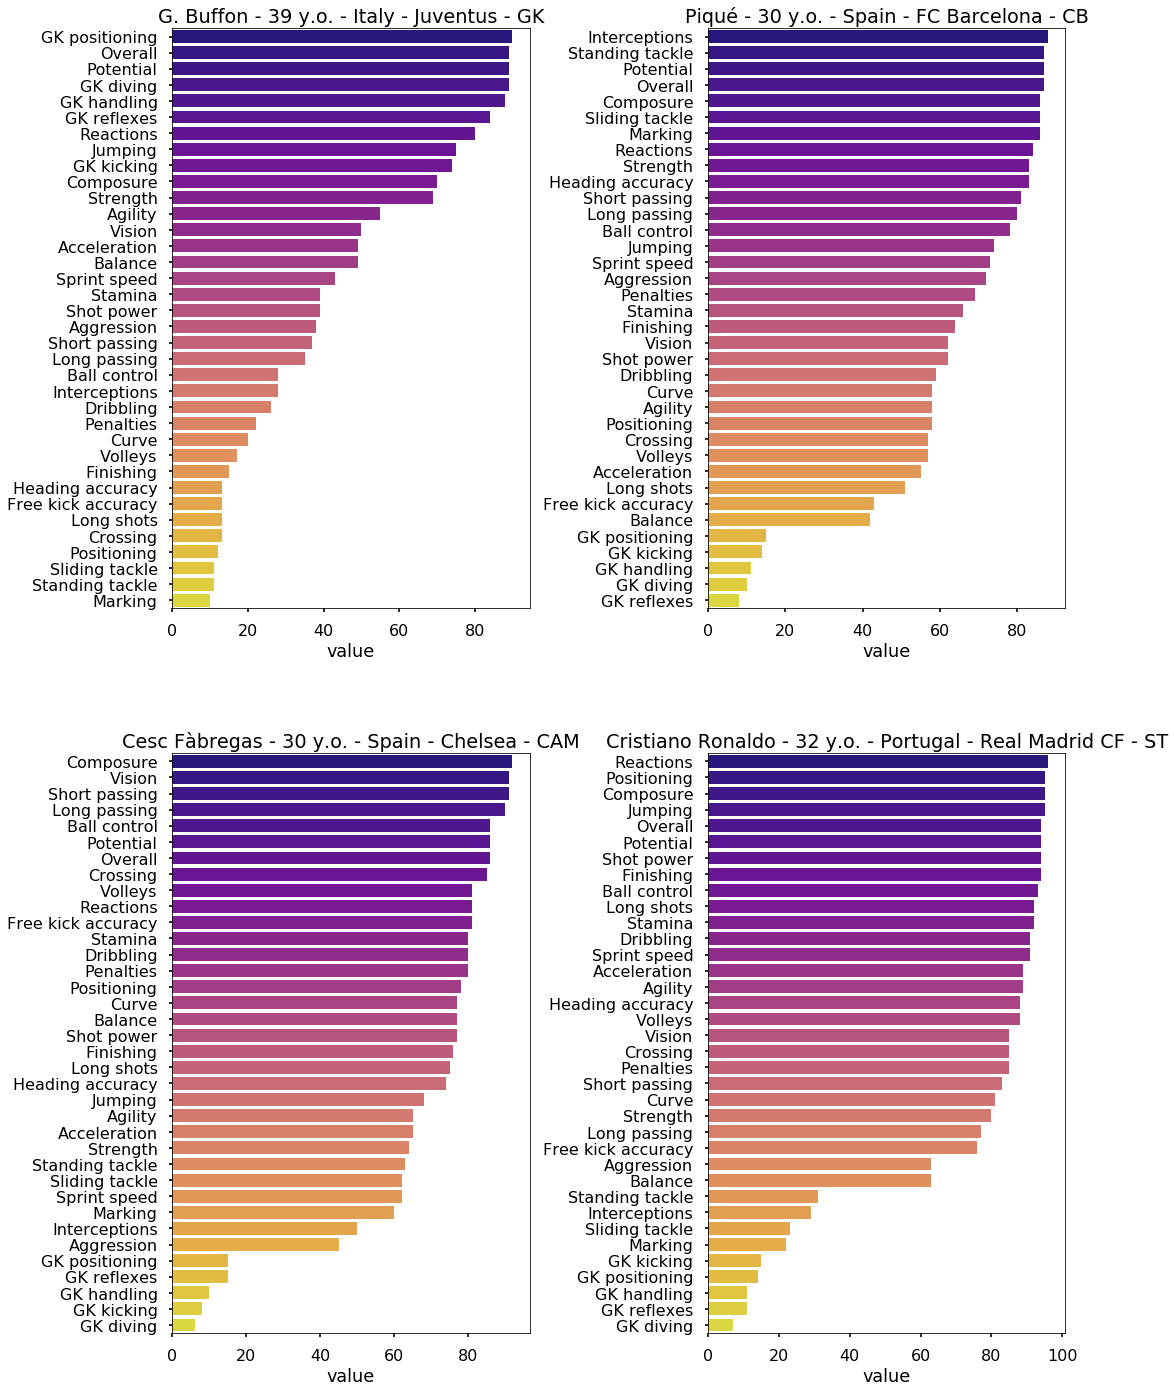

In [7]:
print("Dataset preview: \n")

f, ax = plt.subplots(figsize=(16,24), ncols=2, nrows=2)
plt.subplots_adjust(hspace=.25, wspace=.5)
row = 0
col = 0

for i in [18, 44, 65, 0]:
    _d = pd.DataFrame(
        df.select_dtypes(include=['int','float']).iloc[i].sort_values(ascending=False)
    ).reset_index().rename(columns={'index':'skill',i:'value'})

    _d = _d.loc[(_d['skill'] != 'Age')].copy()
    
    sns.barplot(
        data=_d,
        y=_d['skill'],
        x=_d['value'],
        orient='h',
        palette='plasma',
        ax=ax[row][col]
    )
    
    ax[row][col].set_title("{} - {} y.o. - {} - {} - {}".format(
            df.iloc[i]['Name'],
            df.iloc[i]['Age'],
            df.iloc[i]['Nationality'],
            df.iloc[i]['Club'],
            df.iloc[i]['Preferred Positions_Main']
    ))
    ax[row][col].set_ylabel('')
    
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
        
plt.show();

# Analysis

## Data Exploration

This dataset is dominated by England, Germany, France, Spain and Argentina players. Also, most players are centre back (CB), followed by striker (ST) and goal keeper (GK). Note that positions below are specific to certain role, e.g. centre back, left back, right back could be generalized as back.

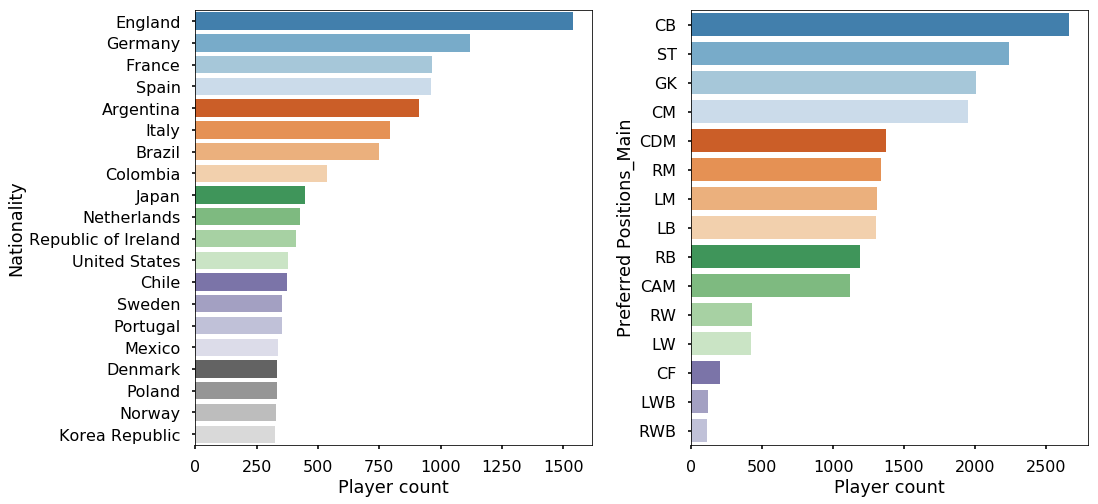

In [8]:
f, ax = plt.subplots(figsize=(16,8), ncols=2)
plt.subplots_adjust(wspace=.25)
i = 0

for col in ['Nationality','Preferred Positions_Main']:
    sns.barplot(
        data=df.groupby(col).agg({'Name':pd.Series.nunique}).reset_index().sort_values(by='Name',ascending=False).head(20),
        y=col,
        x='Name',
        palette='tab20c',
        orient='h',
        ax=ax[i]
    )
    ax[i].set_xlabel('Player count')
    i += 1

plt.show();

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 41 columns):
Name                        17981 non-null object
Age                         17981 non-null int64
Nationality                 17981 non-null object
Overall                     17981 non-null int64
Potential                   17981 non-null int64
Club                        17733 non-null object
Acceleration                17897 non-null float64
Aggression                  17913 non-null float64
Agility                     17910 non-null float64
Balance                     17924 non-null float64
Ball control                17840 non-null float64
Composure                   17887 non-null float64
Crossing                    17885 non-null float64
Curve                       17908 non-null float64
Dribbling                   17850 non-null float64
Finishing                   17867 non-null float64
Free kick accuracy          17932 non-null float64
GK diving                   17955

Note that we have missing values on some records. Later we will use k-nearest neighbours (knn) and k-means; those algorithms require available attributes so that we can calculate distance of each data point. Hence, we **impute the missing values** using its median (based on position and nationality). If the records still have null values even after imputation, we remove them.

In [10]:
# fill missing values using median

group_median = df.groupby(['Preferred Positions_Main','Nationality']).median().reset_index()

for col in group_median.columns:
    if col not in ['Preferred Positions_Main','Nationality']:
        group_median.rename(
            columns={
                col:col+'_grp_med'
            },
            inplace=True
        )

In [11]:
med = pd.DataFrame(
        df.select_dtypes(include=['int','float']).describe().reset_index().pivot_table(index='index').loc['50%'].index,
        df.select_dtypes(include=['int','float']).describe().reset_index().pivot_table(index='index').loc['50%']
).reset_index().rename(columns={'50%':'median',0:'col'})

In [12]:
import math 

df = df.merge(
    group_median,
    how='left',
    on=['Preferred Positions_Main','Nationality']
)

for col in df.select_dtypes(include=['int','float']):
    if 'grp_med' not in col:
        df[col] = df.apply(lambda x: x[col+'_grp_med'] if (math.isnan(x[col])) & ~(math.isnan(x[col+'_grp_med'])) 
                           else med.loc[(med['col'] == col.replace('_grp_med','')),'median'] if (math.isnan(x[col])) & (math.isnan(x[col+'_grp_med'])) 
                           else x[col], axis=1)
        
df.drop(labels=group_median.columns[(~(group_median.columns.isin(['Preferred Positions_Main','Nationality'])))],
       axis=1,
       inplace=True)

# remove records with null value after imputation
df = df[~(df.isnull().any(axis=1))]

# convert to numeric
df = df.convert_objects(convert_numeric=True)

# remove records with null value after imputation
df = df[~(df.isnull().any(axis=1))]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17715 entries, 0 to 17980
Data columns (total 41 columns):
Name                        17715 non-null object
Age                         17715 non-null int64
Nationality                 17715 non-null object
Overall                     17715 non-null int64
Potential                   17715 non-null int64
Club                        17715 non-null object
Acceleration                17715 non-null float64
Aggression                  17715 non-null float64
Agility                     17715 non-null float64
Balance                     17715 non-null float64
Ball control                17715 non-null float64
Composure                   17715 non-null float64
Crossing                    17715 non-null float64
Curve                       17715 non-null float64
Dribbling                   17715 non-null float64
Finishing                   17715 non-null float64
Free kick accuracy          17715 non-null float64
GK diving                   17715

*All clear! No more null values!*

In [14]:
def generalize_position(df_pos):
    if df_pos in ['CB','LB','RB','LWB','RWB']:
        res = 'BACK'
    elif df_pos in ['CDM','CAM','CM','RM','LM']:
        res = 'MIDFIELDER'
    elif df_pos in ['ST','CF','LW','RW']:
        res = 'FORWARD'
    else:
        res = 'GOALKEEPER'
    return res

In [15]:
df['target'] = df['Preferred Positions_Main'].apply(lambda x: generalize_position(x))

On correlation plot below, we observe that:
- goal keepers excel on goal keeping-related skills only
- backs are positively correlated to marking, sliding tackle, standing tackle, and interceptions.
- midfielders have more positively correlated attributes than other positions: free kick accuracy, dribbling, curve, long passing, and many more!
- forwards have moderate positive correlation to finishing, penalties, positioning, also volleys. Note that forwards have negative correlation to defender-related attributes: tackle, marking, interceptions.

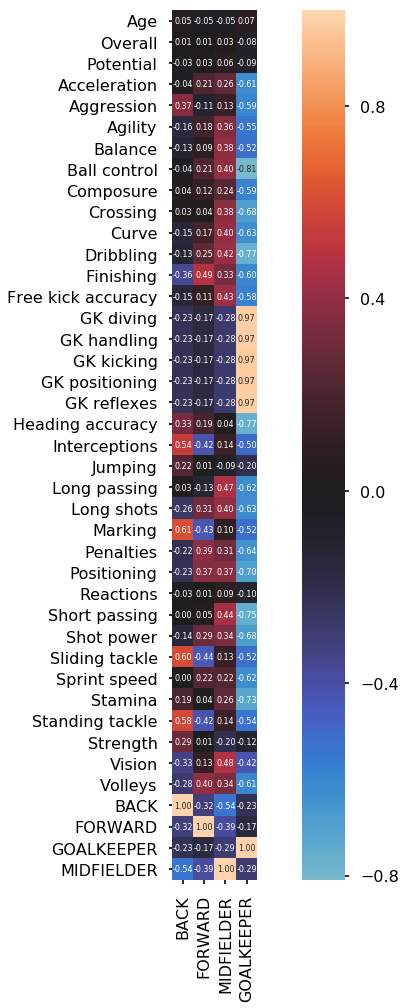

In [16]:
f, ax = plt.subplots(figsize=(16,16))

sns.heatmap(
    df.select_dtypes(include=['int','float']).merge(
        pd.get_dummies(df['target']),
        how='left',
        left_index=True,
        right_index=True
    ).corr()[['BACK','FORWARD','MIDFIELDER','GOALKEEPER']],
    center=0,
    fmt='.2f',
    annot=True,
    annot_kws={'size':8},
    square=True
);

## Classification

*Could we identify football players' position if we know their skill?*

### Use 2 most important features 

As initial approach, we only use two features (so that it's easier to visualize the result).. but which two features should we use? We select them based on their feature importance.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df.select_dtypes(include=['int','float']))
y = df['target']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)

The top 2 important features are sliding and standing tackle - those two, also with heading accuracy are actually correlated. We might not want to include attributes with multicollinearity as input features, since the model will learn redundant information. Thus, we use sliding tackle and GK positioning (4th most important feature) as input features.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RND)
rf.fit(X_train, y_train)

_d = pd.DataFrame(
    [df.select_dtypes(include=['int','float']).columns,
    rf.feature_importances_]
).T.rename(columns={0:'col',1:'feature_importance'}).sort_values(by='feature_importance',ascending=False)

print("Top 10 important features")
print(_d.head(10))

Top 10 important features
                 col feature_importance
30    Sliding tackle          0.0731059
33   Standing tackle          0.0706987
19  Heading accuracy          0.0692668
17    GK positioning          0.0683078
12         Finishing          0.0596071
22      Long passing          0.0503039
14         GK diving          0.0456316
24           Marking          0.0455851
26       Positioning          0.0387269
36           Volleys          0.0348315


We train k-nearest neighbours model using those two attributes, while also checking number of $k$ which should be used - $k = 19$ seems reasonable.

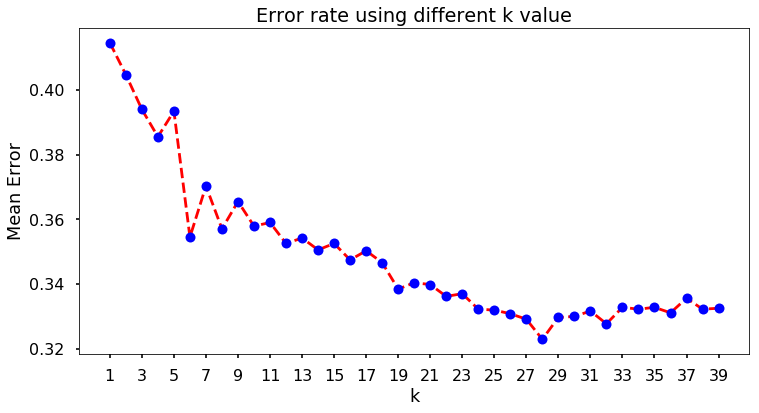

In [19]:
X = scaler.fit_transform(df[['Sliding tackle','GK positioning']])
y = df['target']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)

# plot error
err = plot_knn_error(X_train, y_train, X_test, y_test)

In [20]:
k = 19

knn = KNeighborsClassifier(n_neighbors=21, metric='minkowski', p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)  
show_model_performance(y_test, y_pred, avg='weighted')

Accuracy	: 66.02%
Precision	: 65.87%
Recall		: 66.02%
F1-score	: 65.65%


             precision    recall  f1-score   support

       BACK       0.62      0.74      0.68      1092
    FORWARD       0.66      0.65      0.66       643
 GOALKEEPER       1.00      1.00      1.00       386
 MIDFIELDER       0.59      0.51      0.55      1422

avg / total       0.66      0.66      0.66      3543



Well, using those two attributes, we can clearly predict which one is goal keeper, but not correctly predicting back, midfielder, and forward. Goal keeper is easy to identify, since they only excel in goal keeping skills.

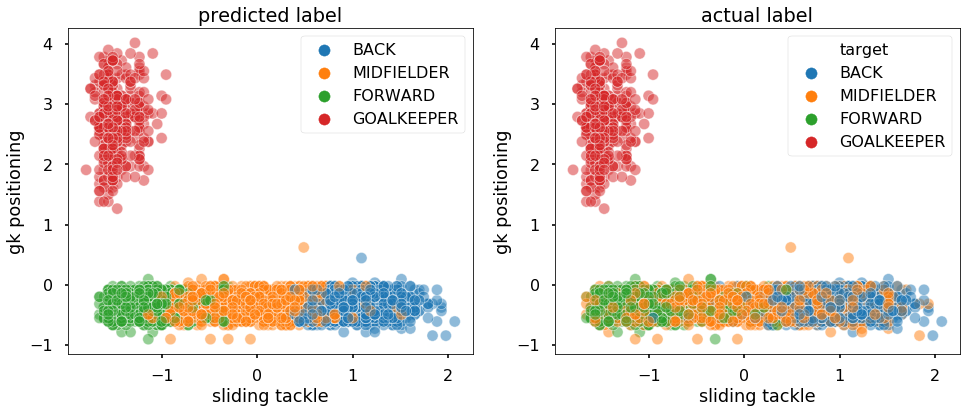

In [21]:
f, ax = plt.subplots(figsize=(16,6), ncols=2)

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_pred,
    alpha = 0.5,
    ax = ax[0]
)

ax[0].set_xlabel("sliding tackle")
ax[0].set_ylabel("gk positioning")
ax[0].set_title("predicted label")

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_test,
    alpha = 0.5,
    ax= ax[1]
)

ax[1].set_xlabel("sliding tackle")
ax[1].set_ylabel("gk positioning")
ax[1].set_title("actual label")

plt.show();

### Use all features as input

What if we put all attributes as input features? We use k=17.

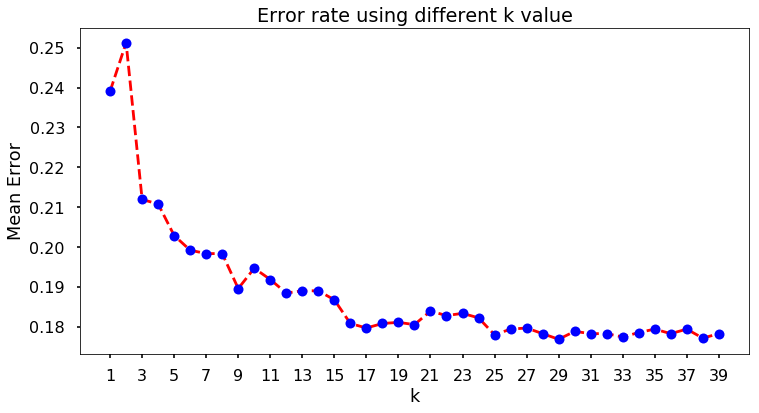

In [22]:
X = scaler.fit_transform(df.select_dtypes(include=['int','float']))
y = df['target']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)

# plot error
err = plot_knn_error(X_train, y_train, X_test, y_test)

We pick $k=17$ - it has better performance!

In [23]:
k = 17

knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)  

show_model_performance(y_test, y_pred, avg='weighted')

Accuracy	: 82.02%
Precision	: 81.94%
Recall		: 82.02%
F1-score	: 81.95%


             precision    recall  f1-score   support

       BACK       0.86      0.87      0.86      1092
    FORWARD       0.75      0.69      0.72       643
 GOALKEEPER       1.00      1.00      1.00       386
 MIDFIELDER       0.77      0.79      0.78      1422

avg / total       0.82      0.82      0.82      3543



### Dimensionality reduction

#### Principal Component Analysis (PCA)

What if we reduce dimensionality of the input features? Could we have model with better performance?

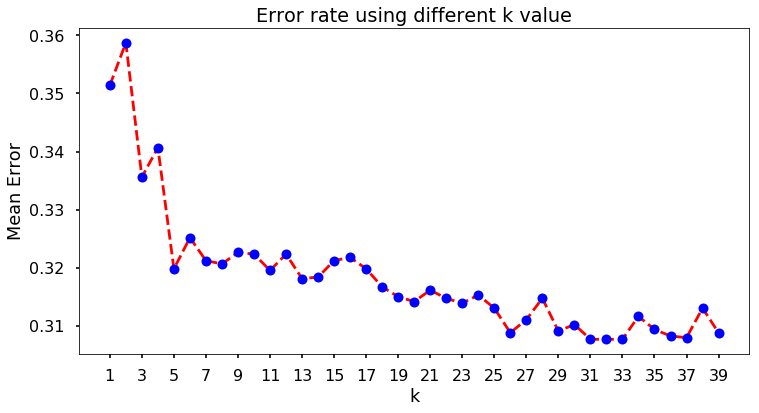

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=RND)
pc = pca.fit_transform(X)

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(pc, y, test_size=0.2, random_state=RND)

# plot error
err = plot_knn_error(X_train, y_train, X_test, y_test)

Here, we use $k=31$; but the performance is not better than the previous model.

In [25]:
k = 31

knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)  

show_model_performance(y_test, y_pred, avg='weighted')

Accuracy	: 69.24%
Precision	: 69.23%
Recall		: 69.24%
F1-score	: 69.20%


             precision    recall  f1-score   support

       BACK       0.77      0.76      0.77      1092
    FORWARD       0.54      0.50      0.52       643
 GOALKEEPER       1.00      1.00      1.00       386
 MIDFIELDER       0.61      0.64      0.63      1422

avg / total       0.69      0.69      0.69      3543



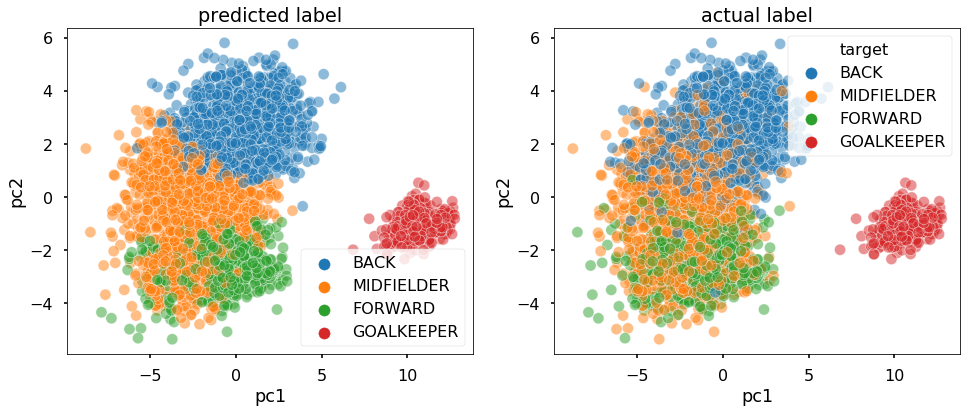

In [26]:
f, ax = plt.subplots(figsize=(16,6), ncols=2)

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_pred,
    alpha = 0.5,
    ax = ax[0]
)

ax[0].set_xlabel("pc1")
ax[0].set_ylabel("pc2")
ax[0].set_title("predicted label")

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_test,
    alpha = 0.5,
    ax= ax[1]
)

ax[1].set_xlabel("pc1")
ax[1].set_ylabel("pc2")
ax[1].set_title("actual label")

plt.show();

#### Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)

/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


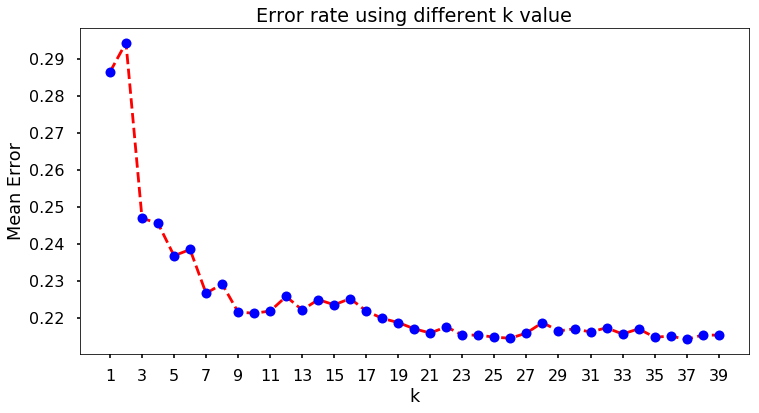

In [27]:
import umap

reducer = umap.UMAP(n_components=2, random_state=RND)
embedding = reducer.fit_transform(X)

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(embedding, y, test_size=0.2, random_state=RND)

# plot error
err = plot_knn_error(X_train, y_train, X_test, y_test)

In [28]:
k = 13

knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)  

show_model_performance(y_test, y_pred, avg='weighted')

Accuracy	: 77.79%
Precision	: 77.86%
Recall		: 77.79%
F1-score	: 77.74%


             precision    recall  f1-score   support

       BACK       0.79      0.81      0.80      1092
    FORWARD       0.77      0.67      0.71       643
 GOALKEEPER       1.00      1.00      1.00       386
 MIDFIELDER       0.72      0.75      0.73      1422

avg / total       0.78      0.78      0.78      3543



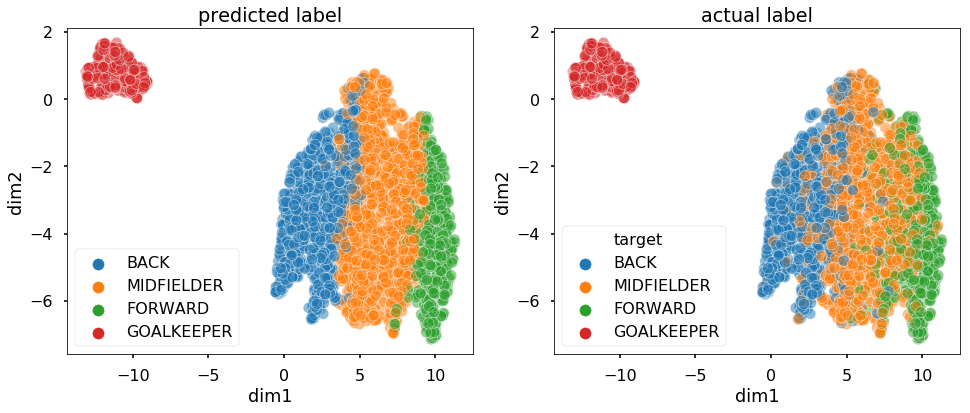

In [29]:
f, ax = plt.subplots(figsize=(16,6), ncols=2)

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_pred,
    alpha = 0.5,
    ax = ax[0]
)

ax[0].set_xlabel("dim1")
ax[0].set_ylabel("dim2")
ax[0].set_title("predicted label")

sns.scatterplot(
    x = [x[0] for x in X_test],
    y = [x[1] for x in X_test],
    hue = y_test,
    alpha = 0.5,
    ax= ax[1]
)

ax[1].set_xlabel("dim1")
ax[1].set_ylabel("dim2")
ax[1].set_title("actual label")

plt.show();

## Clustering

*Can we group football players based on their skill?*

### k-means clustering

We use post-dimensionality reduction attributes as input features, since visualizing the data will be useful on evaluating clustering results.

#### PCA

We use $k=4$, since it shows "elbow" on the scree plot - and we already have our initial assumptions of the data: football players can be grouped into 4 positions.

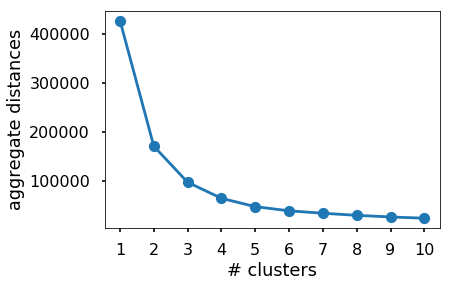

In [30]:
from sklearn.cluster import KMeans

v = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pc)
    v.append(kmeans.inertia_)

plt.plot(range(1,11), v, 'o-')
plt.xticks(range(1,11), range(1,11))
plt.xlabel('# clusters')
plt.ylabel('aggregate distances')
plt.show();

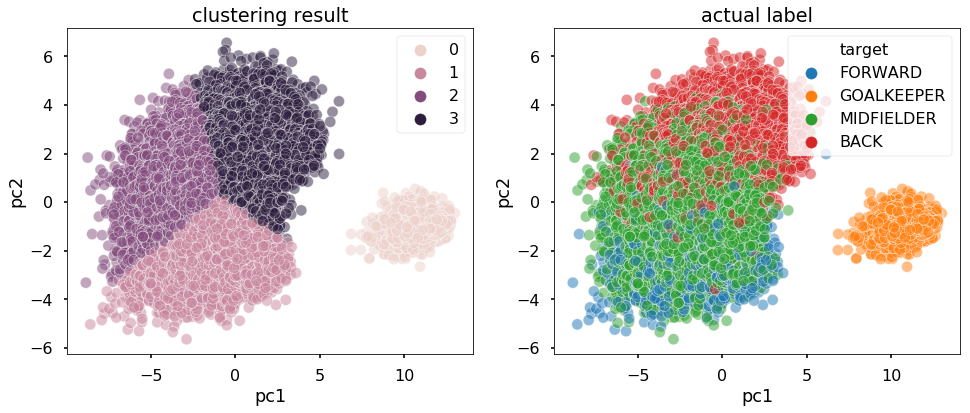

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=RND)
kmeans.fit(pc, y);
clusters = kmeans.labels_

## visualization
f, ax = plt.subplots(figsize=(16,6), ncols=2)

sns.scatterplot(
    x = [x[0] for x in pc],
    y = [x[1] for x in pc],
    hue = clusters,
    alpha = 0.5,
    ax = ax[0]
)

ax[0].set_xlabel("pc1")
ax[0].set_ylabel("pc2")
ax[0].set_title("clustering result")

sns.scatterplot(
    x = [x[0] for x in pc],
    y = [x[1] for x in pc],
    hue = y,
    alpha = 0.5,
    ax= ax[1]
)

ax[1].set_xlabel("pc1")
ax[1].set_ylabel("pc2")
ax[1].set_title("actual label")

plt.show();

#### UMAP

Here, we also use $k=4$.

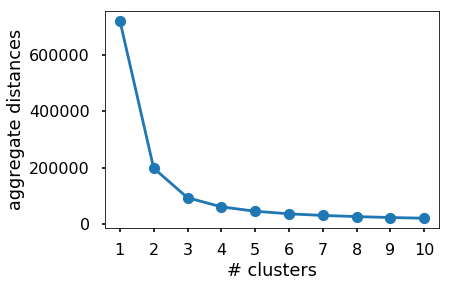

In [32]:
from sklearn.cluster import KMeans

v = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(embedding)
    v.append(kmeans.inertia_)

plt.plot(range(1,11), v, 'o-')
plt.xticks(range(1,11), range(1,11))
plt.xlabel('# clusters')
plt.ylabel('aggregate distances')
plt.show();

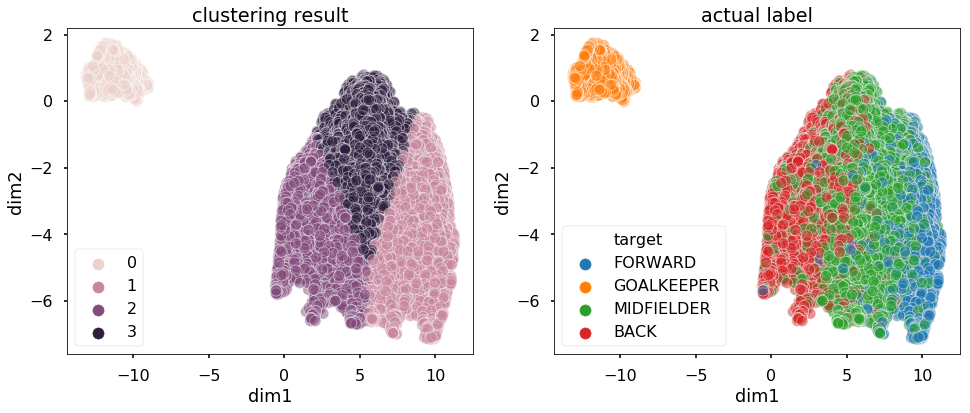

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=RND)
kmeans.fit(embedding, y);

clusters = kmeans.labels_

## visualization
f, ax = plt.subplots(figsize=(16,6), ncols=2)

sns.scatterplot(
    x = [x[0] for x in embedding],
    y = [x[1] for x in embedding],
    hue = clusters,
    alpha = 0.5,
    ax = ax[0]
)

ax[0].set_xlabel("dim1")
ax[0].set_ylabel("dim2")
ax[0].set_title("clustering result")

sns.scatterplot(
    x = [x[0] for x in embedding],
    y = [x[1] for x in embedding],
    hue = y,
    alpha = 0.5,
    ax= ax[1]
)

ax[1].set_xlabel("dim1")
ax[1].set_ylabel("dim2")
ax[1].set_title("actual label")

plt.show();

### Evaluate clustering results

k-means doesn't seem to perform well on this dataset, since the data points don't have linear cluster boundaries. Let's say if we take clustering results from UMAP embedding: how could we interpret the clusters?

The pain points are differentiating forward to midfielder, and also midfielder to back - since those positions have intersected skill.

In [34]:
df['cluster'] = clusters.tolist()

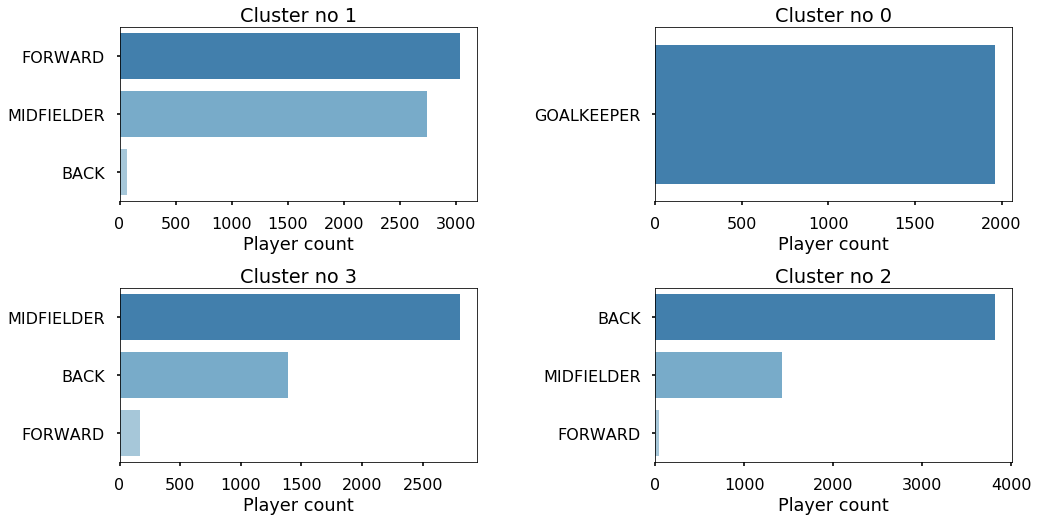

In [35]:
f, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
plt.subplots_adjust(hspace=.5, wspace=.5)

row = 0
col = 0

for cl in df['cluster'].unique():
    sns.barplot(
        data=df.loc[(df['cluster'] == cl)].groupby('target').agg({'Name':pd.Series.nunique}).reset_index().sort_values(by='Name',ascending=False),
        y='target',
        x='Name',
        orient='h',
        palette='tab20c',
        ax=ax[row][col]
    )
    
    ax[row][col].set_title("Cluster no {}".format(cl))
    ax[row][col].set_xlabel("Player count")
    ax[row][col].set_ylabel("")
    
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

plt.show();

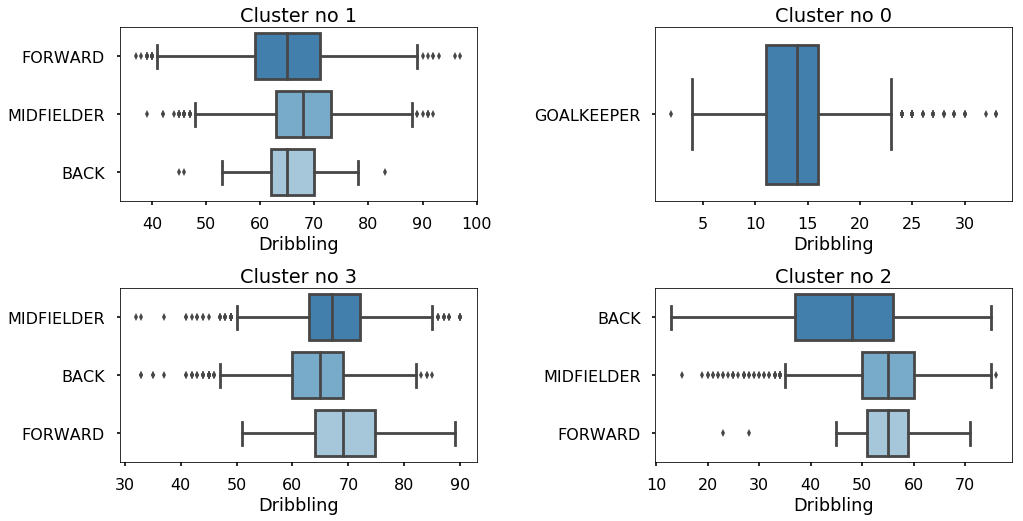

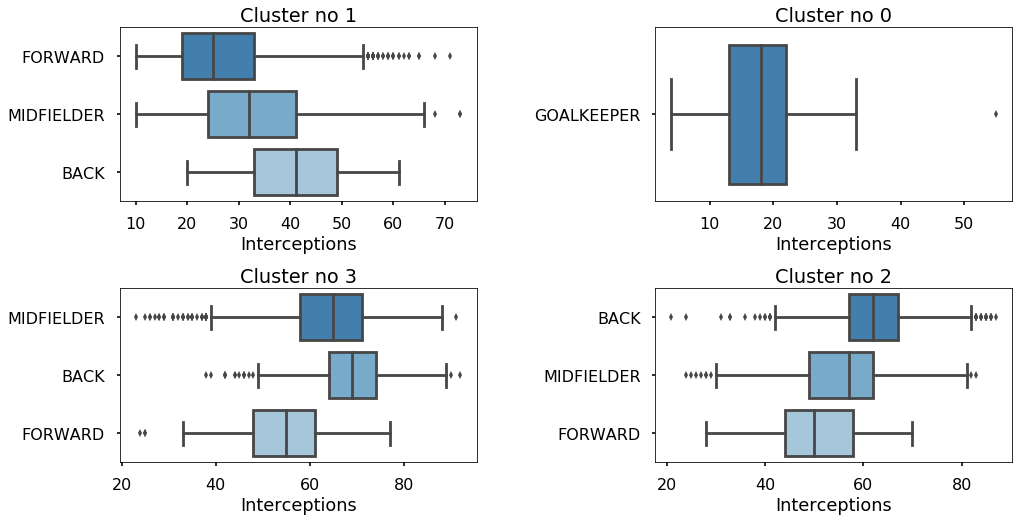

In [36]:
for field in ['Dribbling','Interceptions']:
    f, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
    plt.subplots_adjust(hspace=.5, wspace=.5)

    row = 0
    col = 0

    for cl in df['cluster'].unique():
        sns.boxplot(
            data=df.loc[(df['cluster'] == cl)],
            y='target',
            x=field,
            orient='h',
            palette='tab20c',
            ax=ax[row][col]
        )

        ax[row][col].set_title("Cluster no {}".format(cl))
        ax[row][col].set_xlabel(field)
        ax[row][col].set_ylabel("")

        if col == 1:
            row += 1
            col = 0
        else:
            col += 1

    plt.show();
    print("\n\n")

# Results and Discussions

*describe what you find and how it can be improved*

# References

[1] [K-Nearest Neighbors Algorithm in Python and Scikit-Learn](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/)

[2] [Data Mining - Lab 4: k-Nearest Neighbours & k-Means](https://nbviewer.jupyter.org/github/aliakbars/uai-dm/blob/master/scripts/lab4.ipynb)